
# A3 Problems

This assignment uses data from the WMAP microwave background mapping experiment, a program called Code for Anisotropies in the Microwave Background ([`CAMB`](https://github.com/cmbant/CAMB)), and the Markov Chain Monte Carlo technique to constrain the cosmological parameters of the universe! Yeesh, that's a lofty goal.

However, given CAMB calculates the power spectrum given cosmological parameters for us (and given we're comfortable using this as a black box!), it really isn't too hard to run a Markov Chain and get some constraining results. Let's get started.

### Problem 1

First things first, we need to load in the WMAP data. The columns we care about from the data file are the multipole moment $\ell$, the measured power spectrum $C_\ell$, and the variance in the measurement.

In [1]:
# The CAMB code to calculate power spectra while taking steps to
# different cosmological parameter values
import camb
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
# A library to make nice MCMC corner plots
import corner
from matplotlib import rcParams

In [2]:
arr = np.genfromtxt('wmap_tt_spectrum_9yr_v5.txt')
l = arr[:,0]
wmap_ps = arr[:,1]
sigma = arr[:,2]
var = sigma**2

Let's make a plot of our power spectrum to see what we're working with 

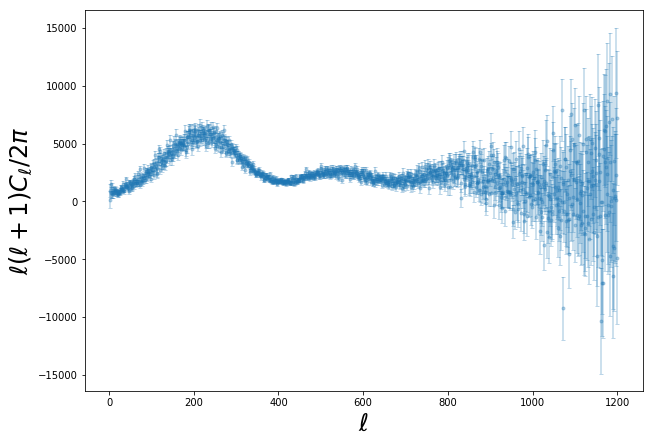

In [3]:
# My preferred plotting parameters
rcParams['figure.figsize'] = (10,7)
plt.errorbar(l, wmap_ps, yerr=sigma, marker='.', ls='', alpha=0.3, capsize=2)
plt.xlabel('$\ell$', fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$', fontsize=24)
plt.show()

Now we'll calculate a model given the parameters in the example script. The parameters used as input to CAMB are:
- $H_0$: The Hubble's constant
- $\omega_b h^2$: The Baryon density scaled by $h = H_0/100$ squared
- $\omega_c h^2$: The cold dark matter density scaled as above
- $\tau$: The optical depth
- $A_s$: The primordial amplitude of fluctuations
- $n_s$: The slope of the primordial power law

For the purposes of this course, since we care about computational methods and not the details of modeling the universe via cosmological parameters, we won't worry too much about the meaning of each parameter. However, we will need to worry about potential correlations between parameters, but we'll touch on that later. For now, we'll just use CAMB to calculate a model and return the $\chi^2$

In [4]:
def get_chisq(data, model, sigma):
    '''
    Get the chisq value for a given array of data, a given
    model expectation, and errors on the data points sigma.
    
    PARAMETERS:
    -----------
    data : array-like
        The array of data values you calculated a model for
    model : array-like
        An array of the same size as data which represents the
        model values for your calculation
    sigma : array-like
        An array of the same size as data which represents errors
        on each data point
    '''
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

def get_spectrum(l, cosmology):
    '''
    Calculate a cosmology spectrum given a set of input params
    using CAMB.
    
    PARAMETERS:
    -----------
    l : array-like
        The multipole moments of the power spectrum
    cosmology : array-like
        An array containing the six cosmological parameters which will
        produce a model power spectrum
        
    RETURNS:
    --------
    C_l_gen_new : array-like
        The model power spectrum returned from CAMB the given values of
        l
    '''
    pars = camb.CAMBparams()
    H0 = cosmology[0]
    ombh2 = cosmology[1]
    omch2 = cosmology[2]
    tau = cosmology[3]
    As = cosmology[4]
    ns = cosmology[5]
    pars.set_cosmology(ombh2=ombh2, omch2=omch2, tau=tau, H0=H0, mnu=0.06, omk=0)
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    pars.set_for_lmax(int(l.max()), lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    C_l_gen_new = powers['total'][int(l.min()):int(l.max()+1),0]
    return C_l_gen_new

In [5]:
pars = np.array([65,0.02,0.1,0.05,2e-9,0.96])
par_strings = ["H0", "wbh2", "wch2", "tau", "As", "ns"]
npars = len(pars)

In [6]:
init_model = get_spectrum(l, pars)
init_chisq = get_chisq(wmap_ps, init_model, sigma)
print("Value of chisq for our initial model is {}".format(init_chisq))

Value of chisq for our initial model is 1588.4257885011234


Great, our value of $\chi^2$ is about 1588, which is what we were told to expect. Note that we assumed the errors on the data are gaussian and uncorrelated (which they are not!), but this is a detail which we'll revisit later. Now let's plot the model and see how it compares to the data before we start fiddling with MCMC chains.

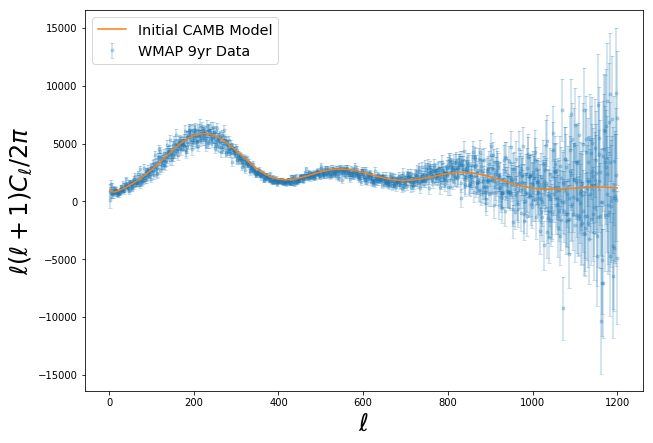

In [7]:
plt.errorbar(l, wmap_ps, yerr=sigma, marker='.', alpha=0.25, ls='', capsize=2, label='WMAP 9yr Data', zorder=0)
plt.xlabel('$\ell$', fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$', fontsize=24)
plt.plot(l, init_model, label='Initial CAMB Model')
plt.legend(fontsize='x-large')
plt.show()

Cool, our model already looks quite good, so we can take these parameters as an initial guess for our MCMC chain.

### Problem 2

Now, keeping $\tau = 0.05$ fixed, we'll find best fit parameters for our other values using Newton's method. Recall from assignment two and class that for minimizing the gradient of $\chi^2$ with respect to parameters $m$, when linearizing, we get an expression:

$$A_m^T N^{-1} A_m \delta m = A_m^T N^{-1} r$$
$$\implies \delta m = \left(A_m^T N^{-1} A_m\right)^{-1} A_m^T N^{-1} r$$

where $A_m = \frac{\partial A}{\partial m}$ and $r$ are the residuals (data - model). Newton's method procedure is as follows:
- Start with a guess for $m_0$
- Calculate $A(m_0)$ and local gradient $A_m$
    - The local gradient can be calculated for each parameter by just taking the derivative of our model for each parameter
- Solve the linear system above for $\delta m$ and iterate $m_{\text{new}} = m_0 + \delta_m$
- Repeat until $\delta m$ is small ($\chi^2 << 1$)

Note that since the mathematical details of our model are hidden in the CAMB blackbox, we're going to have to construct our own numerical derivatives to obtain $A_m$. Given our model has six parameters, for each parameter $x_i$, we can construct a derivative estimate for $A$ with respect to $x_i$ ($A_{x_i}$) using our usual method:

$$A_{x_i} = \frac{A(x_i + \delta x_i) - A(x_i - \delta x_i)}{2\delta x_i}$$

We're going to have to try and make an appropriate choice for $\delta x_i$, which is tricky given again we can't use our traditional methods to find the optimal $\delta x_i$ as $A_{x_i}$ is hidden in the CAMB blackbox.

Here all the $A$ are full CAMB model predictions, and CAMB takes quite a little while to run, so our method for Newton's method could take a while. But, that's the price we pay for doing cool science on our 4-core laptops!

In [8]:
def newton_minimizer(
    data,
    model,
    N_inv,
    fractional_dx,
    pars,
    freeze_tau=True,
    plot=False
):
    '''
    Use Newton's method to find best-fit parameters for the power spectrum of the CMB!
    
    PARAMETERS:
    -----------
    data : array-like
        The array of data values you calculated a model for
    model : array-like
        An array of the same size as data which represents the
        model values for your calculation
    N_inv : array-like
        An array giving the inverse variance of each data point
        on the diagonal
    fractional_dx : array-like
        An array the size of the number of parameters which tells
        what fraction of the initial paramter value will be used
        as a delta to calculate the derivative
    pars : array-like
        The initial list of parameter values
    freeze_tau : bool, optional
        True by default. Freezes tau in the minimization process
    plot : bool, optional
        False by default. If True, plot a diagnostic for the derivative
        
    RETURNS:
    --------
    pars_new : array-like
        The new set of parameters resulting from Newton's method
    delta_pars : array-like
        The error on each parameter from Newton's method
    A_derivs : array-like
        A list of derivatives estimates at each index for each 
        parameter
    '''
    # Freeze tau, which is the third index of the parameters
    if freeze_tau:
        fractional_dx[3] = 0.0
    # Create a list we'll populate with derivatives of A
    A_derivs = np.zeros((len(data), len(pars)))
    # Loop through all parameters except tau and calculate the derivative
    dpars = pars*fractional_dx
    print("dpars: {}".format(dpars))
    if freeze_tau:
        inds_list = [0,1,2,4,5]
    else:
        inds_list = [0,1,2,3,4,5]
    for i in inds_list:
        print("Calculating derivative for {}...".format(par_strings[i]))
        pars_plus = pars.copy()
        # Make an array for A(x_i + dx_i)
        pars_plus[i] = pars_plus[i] + dpars[i]
        pars_minus = pars.copy()
        # Make an array for A(x_i - dx_i)
        pars_minus[i] = pars_minus[i] - dpars[i]
        A_plus = get_spectrum(l, pars_plus)
        A_minus = get_spectrum(l, pars_minus)
        A_m = (A_plus - A_minus)/(2*dpars[i])
        # Plot the difference between models to see how the function is changing for 
        # each parameter (If it barely changes at all or changes too much, we may want
        # to rethink our dpar for that parameter!)
        if plot:
            plt.semilogy(abs(A_plus - A_minus), label="Parameter: {}".format(par_strings[i]))
        A_derivs[:,i] = A_m
        
    if plot:
        plt.xlabel("l", fontsize=20)
        plt.ylabel("$A_+ - A_-$ for Each Parameter", fontsize=20)
        plt.legend()
        plt.show()
    # Get rid of the row that would contain info about tau, since we didn't
    # calculate the derivative for it
    if freeze_tau:
        A_derivs = np.delete(A_derivs, 3, axis=1)
    
    # Now we need to make our residuals array
    r = data - model
    
    # Now calculate change in pars
    delta_pars = np.linalg.inv(A_derivs.T@N_inv@A_derivs)@(A_derivs.T@N_inv@r)
    # Re-insert no change in tau
    if freeze_tau:
        delta_pars = np.insert(delta_pars, 3, 0, axis=0)
    if pars[3] + delta_pars[3] > 0:
        pars_new = pars + delta_pars
        return pars_new, delta_pars, A_derivs
    else:
        print("Tau on this iteration went below zero!")
        return pars, delta_pars, A_derivs

To start out, we'll try taking 1% of the value of each parameter we want to vary as the value of our $\delta x_i$. Also note we'll make our noise matrix ($\sigma^2$ on the diagonal as we're assuming here gaussian uncorrelated noise for now), and also an inverted version.

In [9]:
N = np.diag(var)
N_inv = np.linalg.inv(N)
fractional_dx = np.array([0.01, 0.01, 0.01, 0., 0.01, 0.01])

We'll produce a plot to see how much the model changes for each parameter. If they have wildly different amplitudes in how they change the function we may rethink our $\delta x_i$.

dpars: [6.5e-01 2.0e-04 1.0e-03 0.0e+00 2.0e-11 9.6e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for As...
Calculating derivative for ns...


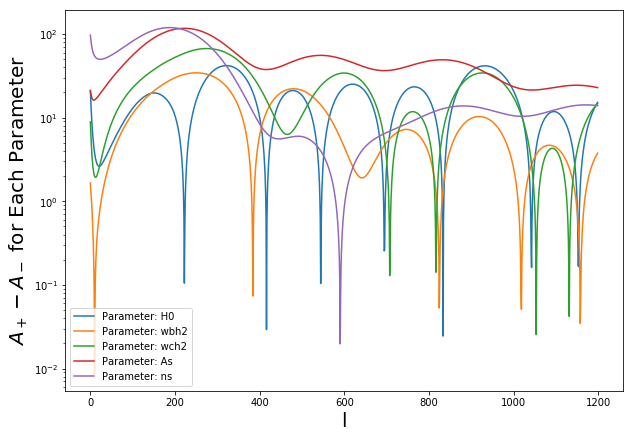

In [10]:
pars_new, dpars, A_d = newton_minimizer(wmap_ps, init_model, N_inv, fractional_dx, pars, plot=True)

Everything seems more or less on the same order of magnitude, so things should be fine with this! Let's check and see how our chisq changed.

In [11]:
model_new = get_spectrum(l, pars_new)
chisq_new = get_chisq(wmap_ps, model_new, sigma)

In [12]:
print("New value for chisq: {}".format(chisq_new))

New value for chisq: 1234.823053175909


Nice! Our $\chi^2$ decreased significantly. So now we can keep iterating Newton's method until the changes in our $\chi^2$ are negligible. I'm also going to decrease the `fractional_dx` a little bit, as I don't want the change to be too severe in each parameter now that we've majorly decreased $\chi^2$ (I could do this more formally by using the LM method, but given I already implemented Newton and it's working well I'll just manually change my step size). I'm also going to make some lists to populate and keep track of how our parameters are changing over the course of these iterations.

In [13]:
fractional_dx_new = fractional_dx*0.25
pars_list = [pars, pars_new]
model_list = [init_model, model_new]
chisq_list = [init_chisq, chisq_new]
delta_chisq = chisq_list[0] - chisq_list[1]
tracker = 1

In [14]:
while delta_chisq > 0.01:
    print("Newton's method iteration {}...".format(tracker))
    pars_new, dpars, A_d = newton_minimizer(wmap_ps, model_list[-1], N_inv, fractional_dx_new, pars_list[-1])
    model_new = get_spectrum(l, pars_new)
    chisq_new = get_chisq(wmap_ps, model_new, sigma)
    pars_list.append(pars_new)
    model_list.append(model_new)
    chisq_list.append(chisq_new)
    delta_chisq = chisq_list[tracker] - chisq_list[tracker + 1]
    tracker += 1
    print("Chisq for this iteration: {} with delta {}\n".format(chisq_new, delta_chisq))

Newton's method iteration 1...
dpars: [1.68350075e-01 5.61404599e-05 2.90490387e-04 0.00000000e+00
 5.17247021e-12 2.41604148e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for As...
Calculating derivative for ns...
Chisq for this iteration: 1227.9219230632423 with delta 6.901130112666806

Newton's method iteration 2...
dpars: [1.73218758e-01 5.62304824e-05 2.84935446e-04 0.00000000e+00
 5.10706497e-12 2.42415813e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for As...
Calculating derivative for ns...
Chisq for this iteration: 1227.9208144628374 with delta 0.0011086004049047915



Cool! It didn't take too many iterations to get us somewhere that looks to be a really good starting point for our MCMC chain given how seemingly optimized $\chi^2$ is now using Newton's method. Let's quickly plot all of our models against the data to make sure nothing is too awry:

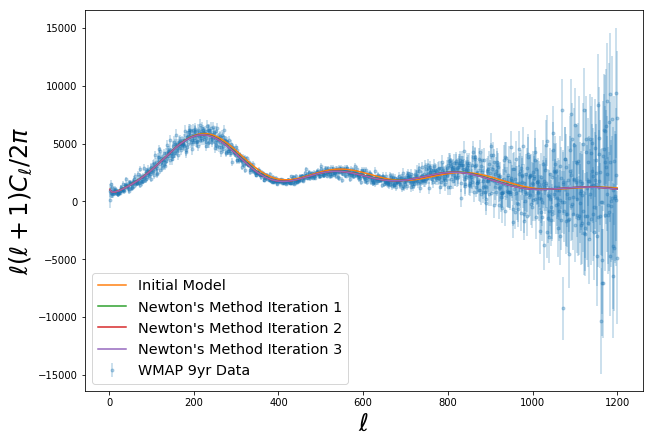

In [15]:
plt.errorbar(l, wmap_ps, yerr=sigma, marker='.', ls='', alpha=0.3, label="WMAP 9yr Data", zorder=0)
plt.xlabel('$\ell$', fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$', fontsize=24)
plt.plot(l, model_list[0], label="Initial Model")
for i in range(1, len(model_list)):
    plt.plot(l, model_list[i], label="Newton's Method Iteration {}".format(i))
plt.legend(fontsize='x-large')
plt.show()

Cool, given that our fits improve $\chi^2$, and the $A(x_i + \delta x_i) - A(x_i - \delta x_i)$ plots don't look crazy, I think we can trust our derivative estimate in the Newton's method iterations. 

Now we'll find the errors on our parameters by looking at the covariance matrix, which is given by
$$\text{Cov} = \left(A_m^T N^{-1} A_m\right)^{-1}$$
and noting the square root of the diagonal terms represents the error on parameter $x_i$. 

In [16]:
cov = np.linalg.inv(A_d.T@N_inv@A_d)
pars_err = np.sqrt(np.diagonal(cov))
pars_err = np.insert(pars_err, 3, 0, axis=0)

In [17]:
for i in range(len(pars)):
    print("Value for %s: %.2e +/- %.2e" % (par_strings[i], pars_list[-1][i], pars_err[i]))

Value for H0: 6.93e+01 +/- 2.40e+00
Value for wbh2: 2.25e-02 +/- 5.39e-04
Value for wch2: 1.14e-01 +/- 5.23e-03
Value for tau: 5.00e-02 +/- 0.00e+00
Value for As: 2.04e-09 +/- 3.90e-11
Value for ns: 9.70e-01 +/- 1.36e-02


In [18]:
L = np.linalg.cholesky(cov)

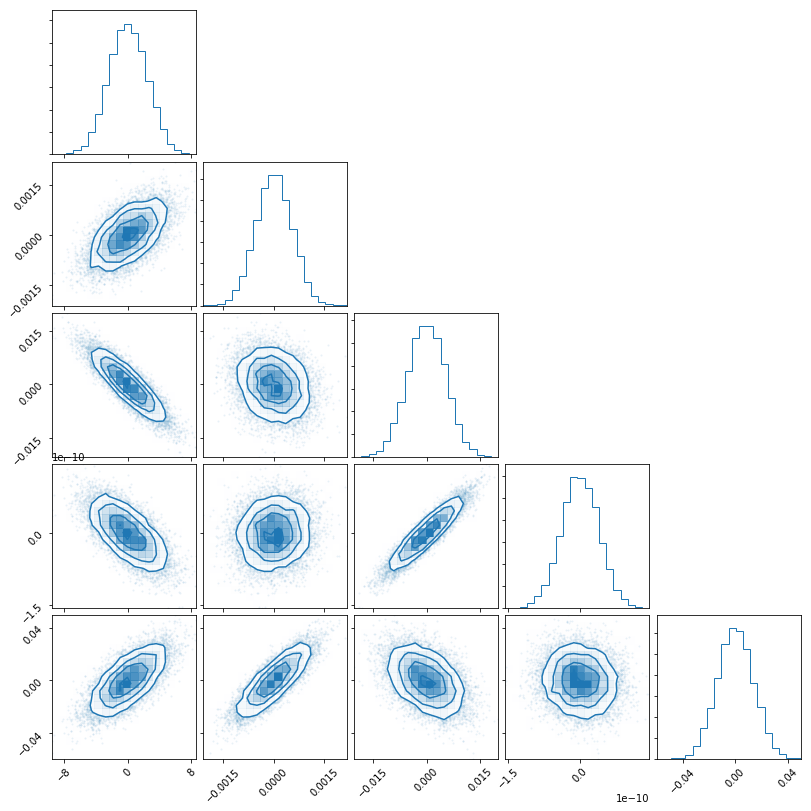

In [19]:
test_samples = np.array(
    [np.dot(L, np.random.randn(L.shape[0])) for i in range(10000)]
)
corner.corner(test_samples,color="C0",max_n_ticks=3)
plt.show()

If we were to float $\tau$, the errors would change based on how they may be covarying with tau itself. However, in general introducing a parameter to your model that is well described by the data should reduce errors, as if $\tau$ describes our model well, allowing it to float should better constrain our other parameters as well. Let's try it.

dpars: [6.5e-01 2.0e-04 1.0e-03 5.0e-04 2.0e-11 9.6e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for tau...
Calculating derivative for As...
Calculating derivative for ns...


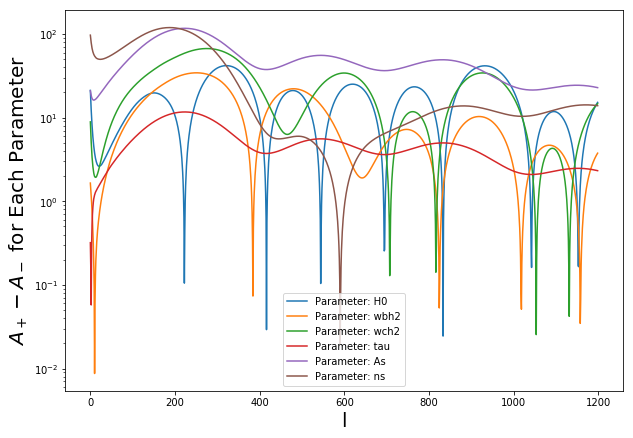

In [20]:
fractional_dx[3] = 0.01
pars_new_free_tau, dpars_free_tau, A_d_free_tau = newton_minimizer(
    wmap_ps, 
    init_model, 
    N_inv, 
    fractional_dx,
    pars,
    freeze_tau=False,
    plot=True
)

In [21]:
model_new_free_tau = get_spectrum(l, pars_new_free_tau)
chisq_new_free_tau = get_chisq(wmap_ps, model_new_free_tau, sigma)

In [22]:
print("New value for chisq: {}".format(chisq_new_free_tau))

New value for chisq: 1235.5440831129513


In [23]:
fractional_dx_free_tau = fractional_dx*0.25
pars_list_free_tau = [pars, pars_new_free_tau]
model_list_free_tau = [init_model, model_new_free_tau]
chisq_list_free_tau = [init_chisq, chisq_new_free_tau]
delta_chisq_free_tau = chisq_list_free_tau[0] - chisq_list_free_tau[1]
tracker = 1

In [24]:
while delta_chisq_free_tau > 0.01:
    print("Newton's method iteration {}...".format(tracker))
    pars_new_free_tau, dpars_free_tau, A_d_free_tau = newton_minimizer(
        wmap_ps, 
        model_list_free_tau[-1], 
        N_inv, 
        fractional_dx_free_tau, 
        pars_list_free_tau[-1],
        freeze_tau=False
    )
    model_new_free_tau = get_spectrum(l, pars_new_free_tau)
    chisq_new_free_tau = get_chisq(wmap_ps, model_new_free_tau, sigma)
    pars_list_free_tau.append(pars_new_free_tau)
    model_list_free_tau.append(model_new_free_tau)
    chisq_list_free_tau.append(chisq_new_free_tau)
    delta_chisq_free_tau = chisq_list_free_tau[tracker] - chisq_list_free_tau[tracker + 1]
    tracker += 1
    print(
        "Chisq for this iteration: {} with delta {}\n".format(
        chisq_new_free_tau, 
        delta_chisq_free_tau
        )
    )

Newton's method iteration 1...
dpars: [1.67873641e-01 5.60354816e-05 2.91269233e-04 9.83132624e-05
 5.06875708e-12 2.41220182e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for tau...
Calculating derivative for As...
Calculating derivative for ns...
Chisq for this iteration: 1227.976300902314 with delta 7.567782210637233

Newton's method iteration 2...
dpars: [1.71997745e-01 5.59395107e-05 2.87053735e-04 4.83947510e-05
 4.80478101e-12 2.41440578e-03]
Calculating derivative for H0...
Calculating derivative for wbh2...
Calculating derivative for wch2...
Calculating derivative for tau...
Calculating derivative for As...
Calculating derivative for ns...
Tau on this iteration went below zero!
Chisq for this iteration: 1227.976300902314 with delta 0.0



Okay it looks like something went awry in our Newton's method on the last step. $\tau$ converged quickly to a certain value on the first step, but then the next step did not further converge. This leaves us with a model having an extra parameter but with the ~same $\chi^2$, meaning the fit is worse. If we look at some [documentaton](https://cosmologist.info/notes/CAMB.pdf) from the author of CAMB, we see that $\tau$ depends on the reionization model, and maybe the data we have aren't easily able to characterize this model.

In [25]:
cov_free_tau = np.linalg.inv(A_d_free_tau.T@N_inv@A_d_free_tau)
pars_err_free_tau = np.sqrt(np.diagonal(cov_free_tau))

In [26]:
for i in range(len(pars_new_free_tau)):
    print("Value for %s: %.2e +/- %.2e" % (par_strings[i], pars_new_free_tau[i], pars_err_free_tau[i]))

Value for H0: 6.88e+01 +/- 2.88e+00
Value for wbh2: 2.24e-02 +/- 6.68e-04
Value for wch2: 1.15e-01 +/- 5.87e-03
Value for tau: 1.94e-02 +/- 1.44e-01
Value for As: 1.92e-09 +/- 5.47e-10
Value for ns: 9.66e-01 +/- 1.84e-02


Further, we see that our value of $\tau$ is consistent with a negative number, which for that parameter is unphysical (based on the definition of $\tau$ it should always be $\geq0$). This isn't promising for our chain with covariant steps, but we'll live with it and proceed as usual.

### Problem 3

In order to run a Markov chain taking covariant steps, note that we can use Cholesky decomposition to draw samples of correlated data from a covariance matrix. [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of a Hermitian positive-definite matrix $A$ (which we expect our matrix to be, given it is a covariance matrix) is given by:
$$A = LL^\dagger$$
where $L$ is a lower triangular matrix with real, positive diagonal entries and $L^\dagger$ is the Hermitian conjugate of $L$. Given the entries in our covariance matrix are all real, this decomposes to $A = LL^T$. Taking $L$ from the decomposition, we can apply $L$ to a vector of uncorrelated samples $u$ and get a sample $Lu$ which has covariance properties of our system.

As a reminder of the MCMC method, 

In [27]:
L = np.linalg.cholesky(cov_free_tau)

Let's take a look at what our covariances look like by pulling random samples with those correlations present

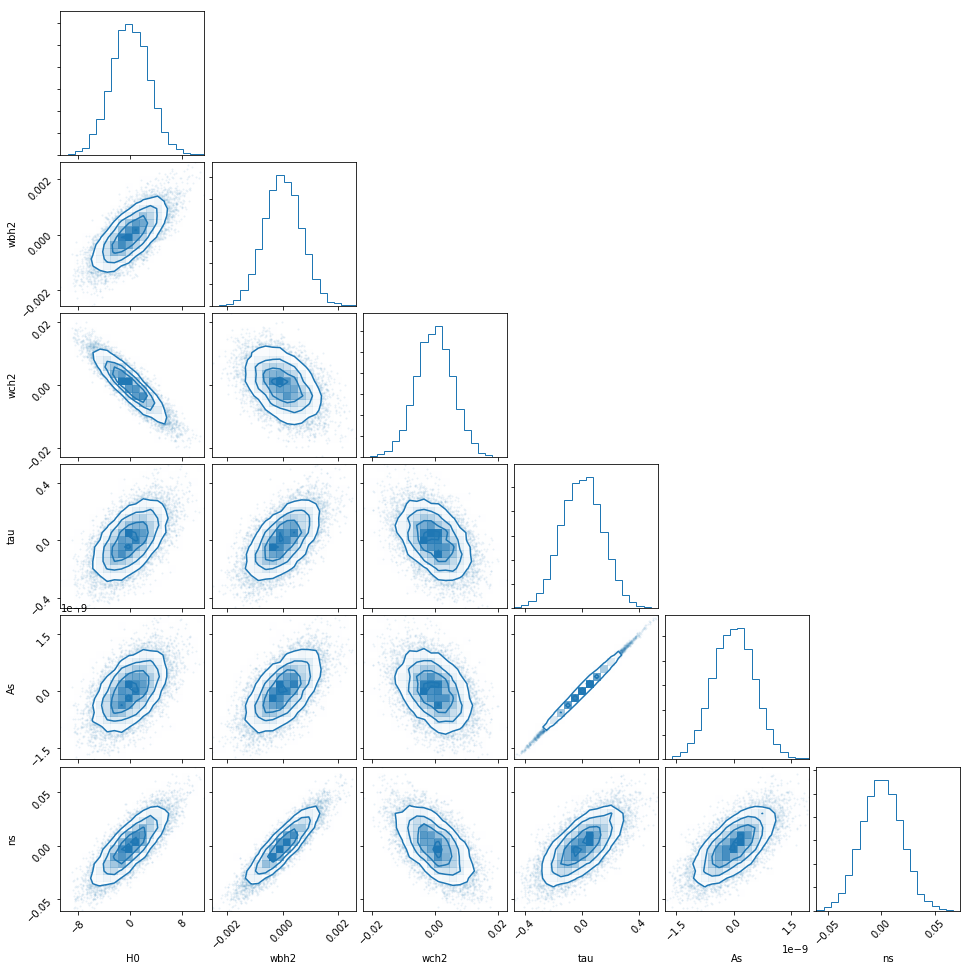

In [29]:
test_samples = np.array(
    [np.dot(L, np.random.randn(L.shape[0])) for i in range(10000)]
)
corner.corner(test_samples,color="C0",max_n_ticks=3,labels=par_strings)
plt.show()

Okay, interesting. It looks like we have some strong correlations between certain parameters (particularly $\tau$ and $A_s$ it seems). Given these extreme correlations we might have some difficulty getting a good result. But the input to the MCMC chain can be adjusted to deal with this as well.

In [30]:
def run_mcmc(
    data,
    err,
    init_cosmology,
    init_chisq,
    L_cov,
    nstep,
    old_chain_fn=None,
    save_fn=None,
    cov_no_tau=0.0
):
    '''
    Run an MCMC chain given a covariance matrix to figure out the
    most likely cosmological parameters for the universe!
    
    PARAMETERS:
    -----------
    data : array-like
        The array of data values you calculated a model for
    err : array-like
        An array of the same size as data which represents the
        errors for each point
    init_cosmology : array-like
        An array giving the initial parameters
    init_chisq : float
        Initial chisq value
    L_cov : array-like
        The Cholesky decomposition of the covariance matrix used to 
        take correlated steps
    nstep : int
        How many steps to take
    old_chain_fn : str, optional
        None by default. If a string is given, find the filename
        containing information from the old chain and load it in
    save_fn : str, optional
        None by default. If a string is given, save the resulting 
        chain at each step to the desired fn.
    cov_no_tau : float, optional
        0 by default. If non-zero float is given, note that the 
        covariance matrix decomposition given doesn't contain
        tau, and instead step a fractional value of tau given
        by this parameter
        
    RETURNS:
    --------
    chain : array-like
        The MCMC chain results
    '''
    # Get number of accepted steps -- we want it to be around 25-30%
    # ideally, and may want to reconsider our covariance matrix or our
    # step size if that's not the case.
    n_accepted = 0
    
    # Load in an old chain if one is provided
    if old_chain_fn is not None:
        try:
            chain = np.load(old_chain_fn)
        except:
            print("Couldn't find file {}, making a new chain!".format(old_chain_fn))
            chain = [[]]*(len(init_cosmology)+2)
            len_chain = 0
    else:
        chain = [[]]*(len(init_cosmology)+2)
        len_chain = 0

    for i in range(len_chain,len_chain+nstep):
        # The zeroth element of axis 1 will be the step number
        chain[0].append(i+1)
        print('On step %.0f' % (i+1))
        
        # This array will have n_pars values corresponding to 
        # the correlated step in each parameter
        if cov_no_tau:
            step = np.dot(L_cov, np.random.rand(L_cov.shape[0]))
            step = np.insert(step, 3, cov_no_tau*init_cosmology[3])
        else:
            step = np.dot(L_cov, np.random.rand(L_cov.shape[0]))
        
        # Update our cosmology parameters with our step
        new_cosmology = init_cosmology + step
        print("New cosmology: {}".format(new_cosmology))
        # Get the new model spectrum
        print("Generating new spectrum...")
        C_l_gen_new = get_spectrum(l, new_cosmology)
        new_chisq = get_chisq(data,C_l_gen_new,err)
        delchisq = new_chisq - init_chisq
        
        # Standard MCMC probability of acceptance
        prob = np.exp(-0.5*delchisq)
        accept = np.random.rand() < prob
        # Adding tau > 0 prior
        accept = accept & (new_cosmology[3] > 0)
        
        if accept:
            print('Step accepted!')
            print('Delta chisq: %.2f' % (delchisq))
            print('Probability: %.2f \n' % (prob))
            
            n_accepted += 1
            init_cosmology = new_cosmology
            init_chisq = new_chisq
        else:
            print("Step rejected. \n")
            
        chain[1].append(init_chisq)
        for i in range(2,len(init_cosmology) + 2):
            chain[i].append(init_cosmology[i - 2])
        
        if save_fn is not None:
            np.save(save_fn, np.array(chain))
        
    print('Percentage of steps accepted: %.2f' % (n_accepted/nstep))
    return chain

Running this chain should do eventually converge to a good set of CMB parameters. I won't run it for this solution set, as it requires a good deal of time and sometimes tweaking of step sizes to get a good step percentage acceptance rate